# Bike Sharing MLR

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

# Data understanding, preparation and EDA

In [2]:
# read data set
bike_share_df = pd.read_csv("day.csv")
bike_share_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# examine columns and datatypes
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### Data Cleaning

In [4]:
# rename the columns  ( make all the columns names are even either short form or full form)
rename_cols = {"dteday":"date","yr":"year","mnth":"month","weathersit":"weather","hum":"humidity"}
bike_share_df.rename(columns=rename_cols, inplace=True)

# temp and atemp variable looks similar, so check the correlation between temp and atemp
bike_share_df[["temp","atemp"]].corr()

,temp,atemp
temp,1.000000,0.991696
atemp,0.991696,1.000000


In [5]:
# drop record index column, temp and atemp are highly correlated, so drop atemp for modeling
bike_share_df.drop(["instant","atemp"], axis=1, inplace=True)

In [6]:
bike_share_df["season"].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [7]:
# data quality check
bike_share_df.isnull().mean()

date          0.0
season        0.0
year          0.0
month         0.0
holiday       0.0
weekday       0.0
workingday    0.0
weather       0.0
temp          0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

### Handle categorical variable

In [8]:
# season
season_dict = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
bike_share_df["season"] = bike_share_df["season"].apply(lambda x: season_dict[x])

# weather
weather_dict = {1:"Clear", 2:"Mist", 3:"Light_Snow", 4:"Heavy_Rain"}
bike_share_df["weather"] = bike_share_df["weather"].apply(lambda x: weather_dict[x])

# year
year_dict = {0: 2018, 1: 2019}
bike_share_df["year"] = bike_share_df["year"].apply(lambda x: year_dict[x])

# month
month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
bike_share_df["month"] = bike_share_df["month"].apply(lambda x: month_dict[x])

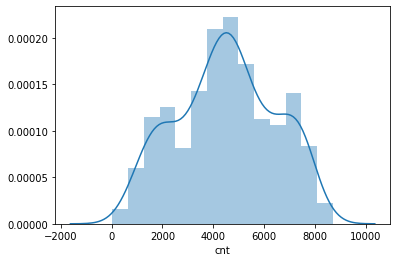

In [9]:
# univariate analysis
sns.distplot(bike_share_df["cnt"])
plt.show()

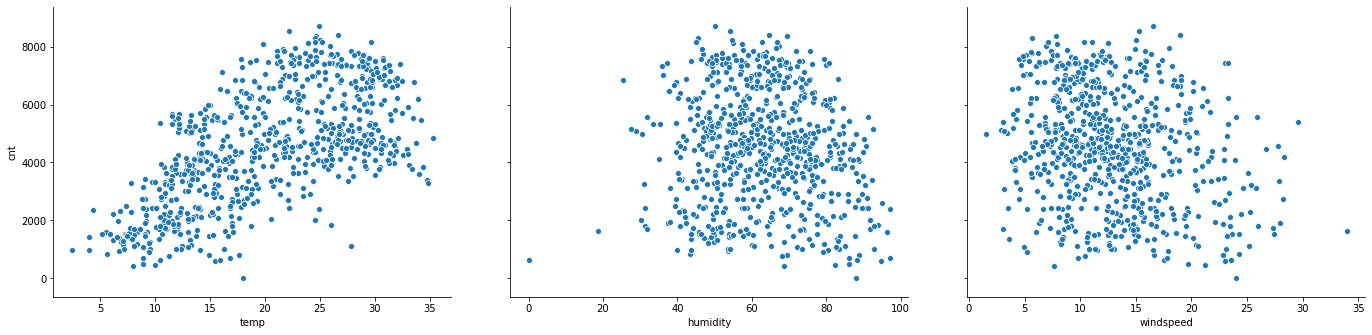

In [10]:
# pair plot
g = sns.pairplot(x_vars=["temp","humidity","windspeed"], y_vars="cnt", data=bike_share_df)
g.fig.set_figheight(5)
g.fig.set_figwidth(20)

plt.show()

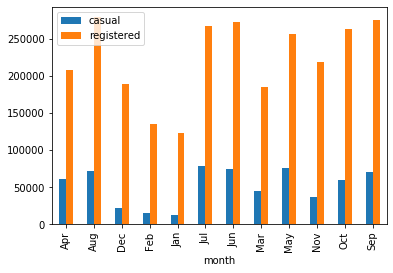

In [11]:
bike_share_df.groupby(by="month")[["casual","registered"]].sum().plot(kind="bar")
plt.show()

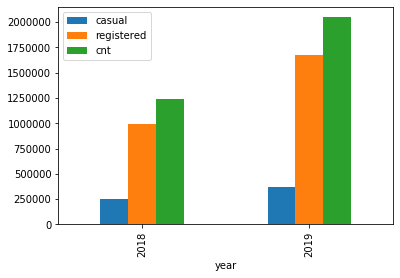

In [12]:
bike_share_df.groupby(by="year")["casual","registered","cnt"].sum().plot(kind="bar")
plt.show()

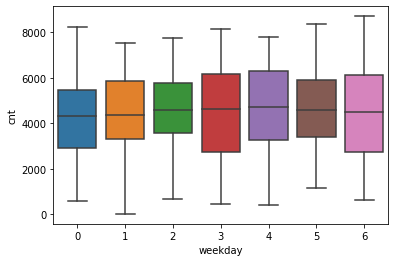

In [13]:
# Bivariate analysis
sns.boxplot(x="weekday", y="cnt", data=bike_share_df)
plt.show()

In [14]:
bike_share_df.groupby("year")["cnt"].sum()

year
2018    1243103
2019    2047742
Name: cnt, dtype: int64

In [18]:
((2047742/1243103)*100)-100
# demand increased as 65% from 2018 to 2019

64.72826467316065

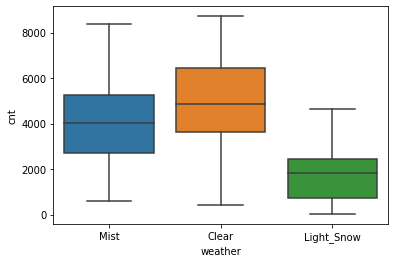

In [19]:
sns.boxplot(x="weather", y="cnt", data=bike_share_df)
plt.show()

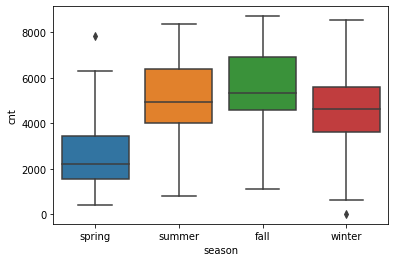

In [20]:
sns.boxplot(x="season", y="cnt", data=bike_share_df)
plt.show()

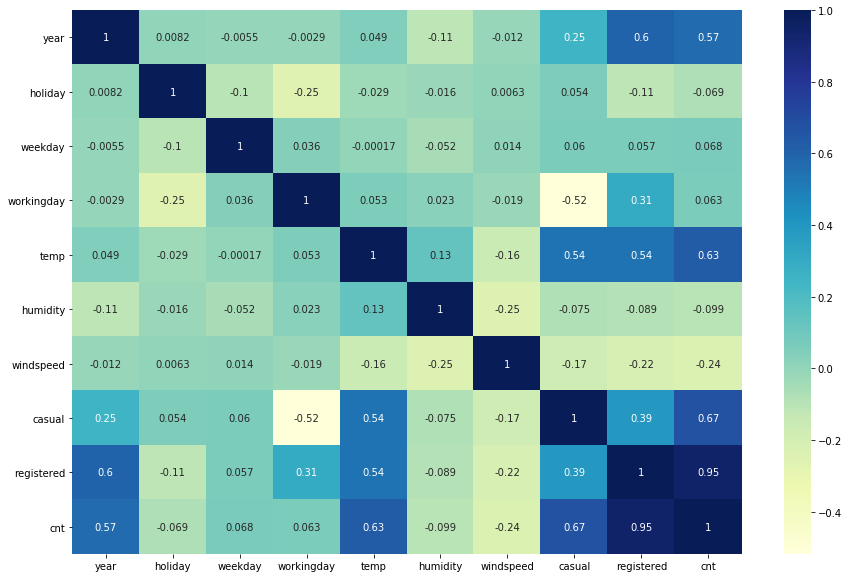

In [21]:
# multivariable analysis
plt.figure(figsize=(15,10))
sns.heatmap(bike_share_df.corr(),annot=True,cmap="YlGnBu")
plt.show()

# EDA observations

- Temperature variable has high positive correlation with target variable cnt.
- windspeed variable has good negative correlation with target variable cnt.
- Clear weather attaracts more bike demand and Mist weather holds the second place.
- Bike sharing demand declining season from fall,summer,winter and spring respectively.
- Bike sharing demand incrased from 2018 to 2019 and registered users holds high usage.

# Preparing data for modeling

In [22]:
bike_share_df["workingday"].value_counts()

1    499
0    231
Name: workingday, dtype: int64

In [23]:
# since the purpose of month variable already covered in season variable, we could drop month,date,weekday columns
bike_share_df.drop(["date","month","weekday"], axis=1, inplace=True)

### Encoding - Creating Dummy variables and Binary Variables

In [24]:
# Enconding

# convert year as binary var
# year
year_dict = {2018:0, 2019:1}
bike_share_df["year"] = bike_share_df["year"].apply(lambda x: year_dict[x])

# Create Dummy variable for season and weather category variables

season_df = pd.get_dummies(bike_share_df["season"],drop_first=True)
weather_df = pd.get_dummies(bike_share_df["weather"],drop_first=True)

In [25]:
# concat the dummy varaible with original dataframe
bike_share_df = pd.concat([bike_share_df,season_df,weather_df],axis=1)

In [26]:
# drop the original category column
# casual + registered = cnt, so we are dropping both the columns
bike_share_df.drop(["season","weather","casual","registered"], axis=1, inplace=True)

In [27]:
bike_share_df.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,spring,summer,winter,Light_Snow,Mist
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,0,0


In [28]:
# split test and train data
df_train, df_test = train_test_split(bike_share_df, train_size=0.7, random_state=100)

In [29]:
# scaling
scaler = MinMaxScaler()
scale_cols = ["temp","humidity","windspeed","cnt"]

# fit and transform
df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
df_train.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,spring,summer,winter,Light_Snow,Mist
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0.204096,1,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,0,1
111,0,0,1,0.345824,0.751824,0.380981,0.191095,0,1,0,0,1


# Model Building and Evaluation

In [30]:
# split X and y variable to build Linear Regression Model
y_train = df_train.pop("cnt")
X_train = df_train

In [31]:
# Feature Selection using Recurisve Feature Elimination
lr = LinearRegression()
rfe = RFE(lr,10)
rfe = rfe.fit(X_train,y_train)
rfe_cols = X_train.columns[rfe.support_]

### selected Features

In [32]:
# Initial selected Features
X_train = X_train[rfe_cols]
X_train.columns

Index(['year', 'holiday', 'temp', 'humidity', 'windspeed', 'spring', 'summer',
       'winter', 'Light_Snow', 'Mist'],
      dtype='object')

In [33]:
# Model building using statsmodel
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(y_train,X_train_sm).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     238.2
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          8.27e-183
Time:                        00:45:37   Log-Likelihood:                 485.99
No. Observations:                 510   AIC:                            -950.0
Df Residuals:                     499   BIC:                            -903.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2932      0.036      8.242      0.000       0.223       0.363
year           0.2307      0.008     27.176      0.000       0.214       0.247
holiday       -0.0860      0.027     -3.224      0.001      -0.138      -0.034
temp           0.4960      0.035     14.316      0.000       0.428       0.564
humidity      -0.1406      0.039     -3.590      0.000      -0.218      -0.064
windspeed     -0.1830      0.027     -6.802      0.000      -0.236      -0.130
spring        -0.0749      0.021     -3.606      0.000      -0.116      -0.034
summer         0.0432      0.014      3.101      0.002       0.016       0.071
winter         0.0871      0.017      5.110      0.000       0.054       0.121
Light_Snow    -0.2396      0.028     -8.701      0.000      -0.294      -0.185
Mist          -0.0522      0.011     -4.761      0.000      -0.074      -0.031
==============================================================================
Omnibus:                       63.872   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.401
Skew:                          -0.644   Prob(JB):                     2.43e-35
Kurtosis:                       5.417   Cond. No.                         19.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# varibale inflation factor - find the highly correlated varibles
def vif(X):
    vif_df = pd.DataFrame()
    vif_df["Features"] = X.columns
    vif_df["vif"] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
    vif_df["vif"] = round(vif_df["vif"],2)
    vif_df= vif_df.sort_values(by="vif", ascending=False)
    return vif_df

In [35]:
vif(X_train)

,Features,vif
3,humidity,26.98
2,temp,14.79
4,windspeed,4.64
5,spring,3.71
7,winter,3.04
9,Mist,2.28
6,summer,2.24
0,year,2.07
8,Light_Snow,1.24
1,holiday,1.04


In [36]:
# drop humidity since it has high vif
X_train.pop("humidity")
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(y_train,X_train_sm).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     257.1
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          2.84e-181
Time:                        00:45:42   Log-Likelihood:                 479.48
No. Observations:                 510   AIC:                            -939.0
Df Residuals:                     500   BIC:                            -896.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2222      0.030      7.427      0.000       0.163       0.281
year           0.2341      0.009     27.423      0.000       0.217       0.251
holiday       -0.0872      0.027     -3.231      0.001      -0.140      -0.034
temp           0.4662      0.034     13.698      0.000       0.399       0.533
windspeed     -0.1546      0.026     -5.942      0.000      -0.206      -0.103
spring        -0.0827      0.021     -3.959      0.000      -0.124      -0.042
summer         0.0382      0.014      2.726      0.007       0.011       0.066
winter         0.0745      0.017      4.416      0.000       0.041       0.108
Light_Snow    -0.2785      0.026    -10.873      0.000      -0.329      -0.228
Mist          -0.0750      0.009     -8.291      0.000      -0.093      -0.057
==============================================================================
Omnibus:                       62.352   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.141
Skew:                          -0.634   Prob(JB):                     5.57e-34
Kurtosis:                       5.366   Cond. No.                         16.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
vif(X_train)

,Features,vif
3,windspeed,4.60
2,temp,3.56
0,year,2.07
4,spring,1.95
5,summer,1.80
6,winter,1.61
8,Mist,1.53
7,Light_Snow,1.08
1,holiday,1.04


### Residual analysis

In [38]:
# calculate Error terms
y_train_pred = lr_model.predict(X_train_sm)
res = y_train-y_train_pred

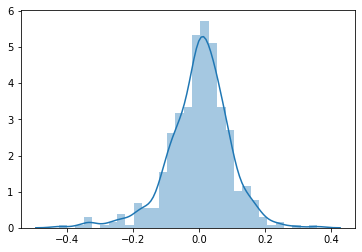

In [39]:
# check error terms are normally distributed
sns.distplot(res)
plt.show()

# prediction and evalution on test set

In [40]:
# scaling the test set
scale_cols = ["temp","humidity","windspeed","cnt"]

df_test[scale_cols] = scaler.transform(df_test[scale_cols])
df_test.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,spring,summer,winter,Light_Snow,Mist
184,0,1,0,0.831783,0.657364,0.084219,0.692706,0,0,0,0,1
535,1,0,1,0.901354,0.610133,0.153728,0.712034,0,1,0,0,0
299,0,0,1,0.511964,0.837699,0.334206,0.303382,0,0,1,0,1
221,0,0,1,0.881625,0.437098,0.339570,0.547400,0,0,0,0,0
152,0,0,1,0.817246,0.314298,0.537414,0.569029,0,1,0,0,0


In [41]:
# split x and y varaibles
y_test = df_test.pop("cnt")
X_test = df_test[X_train.columns]

In [42]:
# add constant for stats model prediction
X_test_sm = sm.add_constant(X_test)
y_test_pred = lr_model.predict(X_test_sm)

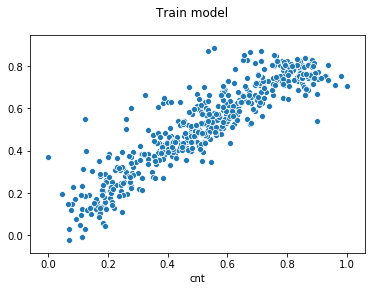

In [43]:
# understand the train model spread
fig = plt.figure()
fig.suptitle("Train model")
sns.scatterplot(x=y_train,y=y_train_pred)
plt.show()

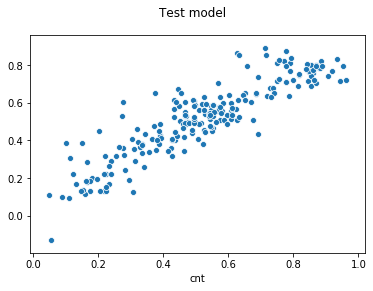

In [44]:
# understand the test model spread
fig = plt.figure()
fig.suptitle("Test model")
sns.scatterplot(x=y_test,y=y_test_pred)
plt.show()

In [45]:
# r2 squared value for test model
r2_score(y_true=y_test,y_pred=y_test_pred)

0.8013092375478268

# conculsion

- holiday, humidity, windspeed, spring season, Light_Snow and Mist weather feature variables are negatively correlated with target variable.
- year, temp, summer and winter season feature variables are positively correlated with target variable.


##### interpretation

$ cnt = 0.2341  \times  year  -0.0872  \times  holiday + 0.4662 \times temperature  -0.1546	 \times windspeed -0.0827 \times spring-season + 0.0382 \times summer-season + 0.0745 \times winter season -0.2785 \times Light-snow weather -0.0750 \times Mist-weather + 0.2222 $